# Results

In [1]:
import pathlib
import rlmate.storage as storage
import rlmate.plot as hplt

# disable some warnings not related to our experiments
import warnings
warnings.simplefilter("ignore")

# 1. Train an NN

The following commands can be executed in order to learn a neural network for the respective models.

## 1.1. Racetrack

For *Racetrack* we use the Python Package [racetrack](https://pypi.org/project/racetrack/), which provides a configurable JANI model for the racetrack benchmark. 

By executing the following cell, our racetrack experiments are reproduced. 

Note that learning an NN for racetrack takes a considerable amount of RAM and time. Depending on your machine, this might not work within the virtual machine. We recommend to use at least 24 GB of RAM. You can skip the next command and instead execute the learning commands for the other models, which are less ressource consuming.

In [ ]:
!hermes exec -f learn_racetrack.hermes -n 'racetrack' --root '../'

The [`learn_racetrack.hermes`](../mogym/learn_racetrack.hermes) file specifies how the job shall be processed: We make use of the neural network defined in [`fcn.py`](../mogym/fcn.py) (`-nnf`) using the following structure `15 64 64 9` (`-nnw`) (15 input neurons, 9 output neurons, and two hidden layers of size 64 in between). The exploration coefficient epsilon is in the beginning set to 1 (`-es`) and is exponentially decayed until the value 0.001 (`-ee`) is reached. The training takes 8000 episodes (`-ne`). Further, this file specifies that the script [`learn_racetrack.py`](../mogym/learn_racetrack.py) should be used for training. In the latter one can find
- the initialization of the racetrack environment with the MoGym package and its API,
- the initialization of the DQN agent, and
- the actual start of the training.


All of the following experiments work analogously, which is why we don't provide another detailed description for them.

The following code produces and displays the training curve (which is a part of Fig. 1 of the paper):

<module 'matplotlib.pyplot' from '/home/koehlma/momba-learning/.venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

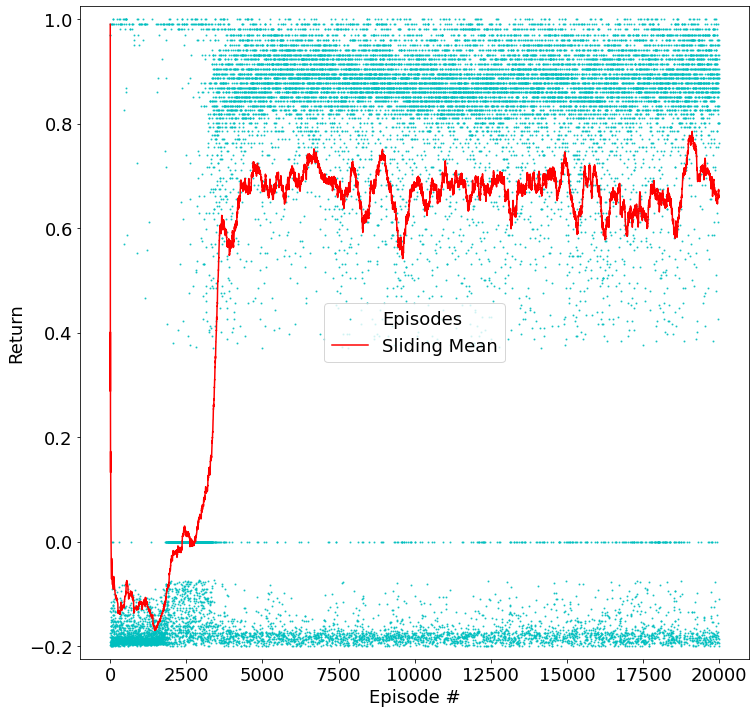

In [2]:
experiment = storage.Experiment.load('../experiments/learn_racetrack/racetrack2/2022_01_20_210439836184_5_fbdf8')
scores = experiment.scores()
hplt.plot_training_progress(scores)

## 1.2. cdrive

For *cdrive* (using the `cdrive.2` QVBS model) execute:

In [ ]:
!hermes exec -f learn_cdrive.hermes -n 'cdrive'  --root '../'

This will take about 3 minute to complete.

An contrast to *Racetrack*, we load an actual JANI model here using the Momba function `jani.load` (see [learn_cdrive.py](./learn_cdrive.py)).

The following code produces and displays the training curve (which is a part of Fig. 1 of the paper):

<module 'matplotlib.pyplot' from '/home/koehlma/momba-learning/.venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

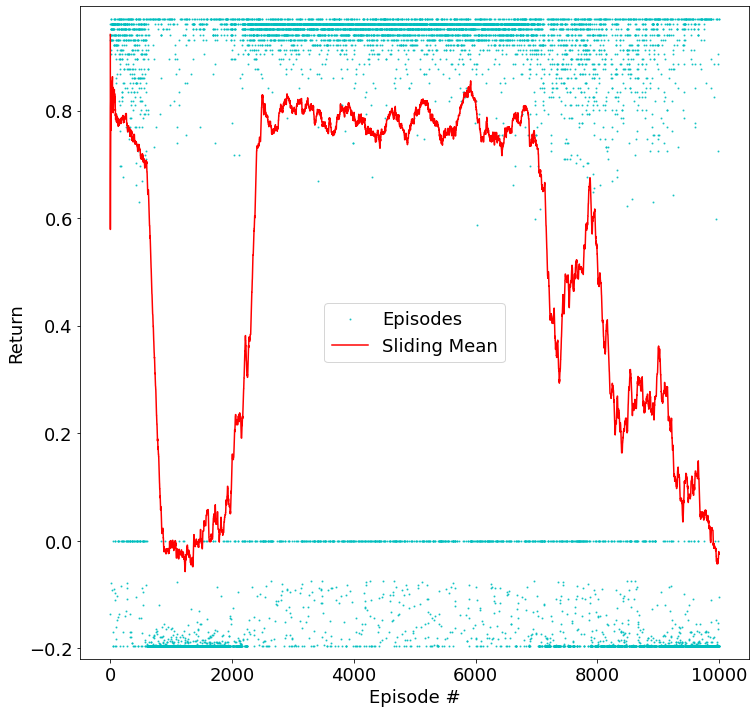

In [3]:
experiment = storage.Experiment.load('../experiments/learn_cdrive/cdrive/2022_01_20_133255623656_1_664e5/')
scores = experiment.scores()
hplt.plot_training_progress(scores)

### 1.3. elevators

Executing the learning script for *elevators* will take around 50 minutes. 3 different NNs are trained:

In [ ]:
!hermes exec -f learn_elevators.hermes -n 'elevators' --root '../'

The following code produces and displays a training curve. You can also switch the experiment number (`2021_11_03_165704354043_c5bb2`) to display another of the experiments. Have a look in the respective experiments directory for additional experiments.

<module 'matplotlib.pyplot' from '/home/koehlma/momba-learning/.venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

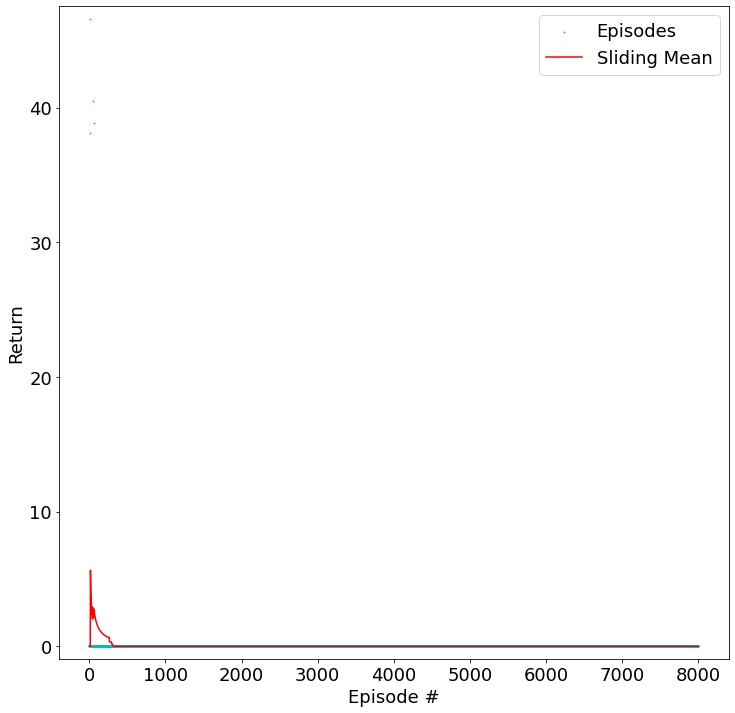

In [4]:
experiment = storage.Experiment.load('../experiments/learn_elevators/elevators/2021_11_03_165704354043_c5bb2/')
scores = experiment.scores()
hplt.plot_training_progress(scores)

### 1.4. firewire_dl

Executing the learning script for *firewire* will take 40 minutes. Again 3 NNs are trained:

In [ ]:
!hermes exec -f learn_firewire.hermes -n 'firewire' --root '../'

The following code produces and displays a training curve. You can also switch the experiment number to display another of the experiments. Have a look in the respective experiments directory for additional experiments.

<module 'matplotlib.pyplot' from '/home/koehlma/momba-learning/.venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

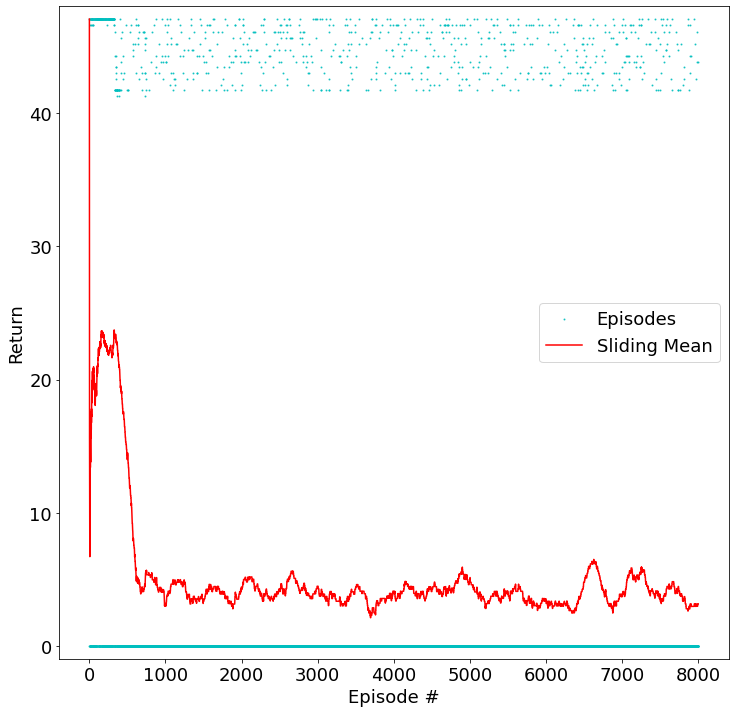

In [5]:
experiment = storage.Experiment.load('../experiments/learn_firewire/firewire/2021_11_03_181436708449_c5bb2/')
scores = experiment.scores()
hplt.plot_training_progress(scores)

# 2. Assessing the Quality of an NN

Here we demonstrate how the modified version of the statistical model checker `modes` can be used to asses the quality of a trained agent. To this end, the nondeterminism in the model occurring during statistical model checking is resolved using the NN. Later, we also show how the probabilistic model checker `mcsta` can be invoked on the model using Momba to check the optimal goal probability.

This demonstrates the functions `check_nn` and `check_oracle` (see paper).

Please note, that in the following, `modes` and `mcsta` may need several minutes to calculate the results, i.e., it may take some time until you see the result when executing the cell.

In [6]:
import asyncio
import pathlib

from momba.gym import checker
from momba.tools import modest

from mogym.load_nn import load_nn

# the `mcsta` probabilistic model checker of The Modest Toolset
mcsta = modest.get_checker(accept_license=True)

# the asyncio loop used internally by Jupyter
loop = asyncio.get_event_loop()

# used to load the NNs of multiple episodes
def load_episode_nns(path):
    import re
    
    policies = {}
    for path in EXPERIMENT_PATH.glob("*.json"):
        match = re.search("_([0-9]+).json", path.name)
        if not match:
            continue
        episode = int(match[1])
        policies[episode] = load_nn(path)
    return policies

## 2.1. Racetrack

In [7]:
from mogym import learn_racetrack

EXPERIMENT_PATH = pathlib.Path("../experiments/learn_racetrack/racetrack2/2022_01_20_210439836184_5_fbdf8")

When calling `modes` on our NN for `Racetrack` we obtained a goal probability of `86.69%`. This will take about 2 minutes.

The optimal goal probability of `99.99%` can be checked by invoking the probabilistic model checker `mcsta` on the model.

In [9]:
optimal_probability = float(mcsta.check(learn_racetrack.network)["goalProbability"])
print(f"Optimal Probability: {optimal_probability}")

Optimal Probability: 0.999955338445111


In [13]:
from concurrent import futures

pool = futures.ThreadPoolExecutor(max_workers=8)

def analyze_racetrack_episodes(path):
    options = checker.ModesOptions(additional_options=["-C", "0.99"])
    
    def check_nn(item):
        episode, nn = item
        result = float(checker.check_nn(learn_racetrack.network, learn_racetrack.controlled_instance, nn, options=options)["goalProbability"])
        return (episode, result)
        
    return list(pool.map(check_nn, load_episode_nns(path).items()))

results = analyze_racetrack_episodes(EXPERIMENT_PATH)
print(results)

[(17999, 0.8931583880037488), (2999, 0.050437828371278456), (4999, 0.6470299057763211), (1999, 0.050437828371278456), (999, 0.06189069423929099), (8999, 0.5881737107405971), (10999, 0.9050567595459237), (14999, 0.7650025733401956), (13999, 0.7643884892086331), (3999, 0.9556420233463035), (7999, 0.9730434782608696), (6999, 0.862911877394636), (15999, 0.9231242312423125), (19999, 0.9647887323943662), (11999, 0.25687894992707827), (9999, 0.9084132055378061), (16999, 0.7406280193236715), (18999, 0.3746501399440224), (5999, 0.9132516703786192), (12999, 0.7490873211642822)]


Maximal goal reachability probability achieved by extracted neural networks

In [34]:
max(results.values())

0.9730434782608696

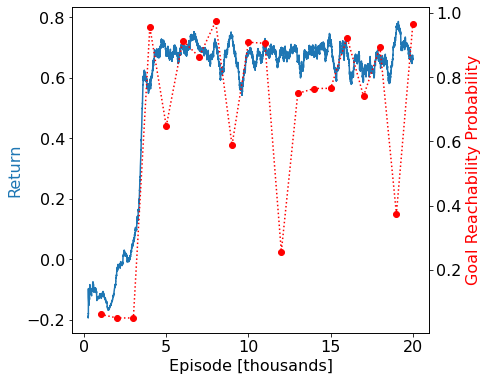

In [20]:
import numpy as np
from matplotlib import pyplot as plt

r = {}
for res in results:
    r[int(res)] = results[res]
    
results = r


# take the grps from the analysis
grps = []
x_grps = []
for episode in sorted(results):
    x_grps.append(int(episode)+1)
    grps.append(results[episode])
x_grps = np.array(x_grps)/1000

# load the scores from experiment
experiment = storage.Experiment.load('../experiments/learn_racetrack/racetrack2/2022_01_20_210439836184_5_fbdf8/')
scores = experiment.scores()

# parameters for sliding mean
max_len = len(scores)
batch_size = 250
# calculate the sliding mean
d = []
sliding_means = []
for i, score in enumerate(scores[batch_size-1:max_len]):
    if i < batch_size:
        d.append(score)
    else:
        d[i%batch_size] = score
    new_value = np.mean(d)
    sliding_means.append(new_value)
    
# plot sliding mean and grp
fontsize = 16
fig, ax1 = plt.subplots(figsize=[6.4, 6])
ax2 = ax1.twinx()

x_means = (np.array(range(len(sliding_means)))+batch_size)/1000
ax1.plot(x_means, sliding_means, label = 'racetrack', color = 'tab:blue')
ax2.plot(x_grps, grps, linestyle = "dotted", color = "red", marker = 'o')

ax1.set_xlabel('Episode [thousands]', fontsize = fontsize)
ax1.set_ylabel('Return', fontsize = fontsize, color = 'tab:blue')
ax1.tick_params(labelsize = fontsize)
ax2.tick_params(labelsize=fontsize)
ax2.set_ylabel("Goal Reachability Probability", fontsize=fontsize, color = "red")

fig.savefig("../racetrack-plot.pdf", bbox_inches="tight")
fig.savefig("../racetrack-plot.png", bbox_inches="tight")

## 2.2. cdrive.2

In [23]:
from mogym import learn_cdrive

In [24]:
EXPERIMENT_PATH = pathlib.Path("../experiments/learn_cdrive/cdrive/2022_01_20_133149959763_0_664e5/")

The optimal goal probability of `86.45%` can be checked by invoking the probabilistic model checker `mcsta` on the model.

In [25]:
optimal_probability = float(mcsta.check(learn_cdrive.network)["goal"])
print(f"Optimal Probability: {optimal_probability}")

Optimal Probability: 0.8645657165326853


We now analyze the goal reaching probability for cdrive over a subset of the training episodes:

In [26]:
def analyze_cdrive_episodes(path):
    options = checker.ModesOptions(additional_options=["-C", "0.99"])

    return {
        episode: float(checker.check_nn(learn_cdrive.network, learn_cdrive.instance, nn, options=options)["goal"])
        for episode, nn in load_episode_nns(path).items()
    }

In [27]:
results_cdrive = analyze_cdrive_episodes(EXPERIMENT_PATH)

In [30]:
results_cdrive

{9999: 0.861919268849962,
 6999: 0.862911877394636,
 8999: 0.8645510835913313,
 999: 0.808982748364069,
 2999: 0.8623376623376623,
 5999: 0.8650116369278511,
 3999: 0.8637413394919169,
 7999: 0.863489623366641,
 1999: 0.8657320872274143,
 4999: 0.8608333333333333}

Maximal goal reachability probability achieved by extracted neural networks

In [35]:
max(results_cdrive.values())

0.8657320872274143

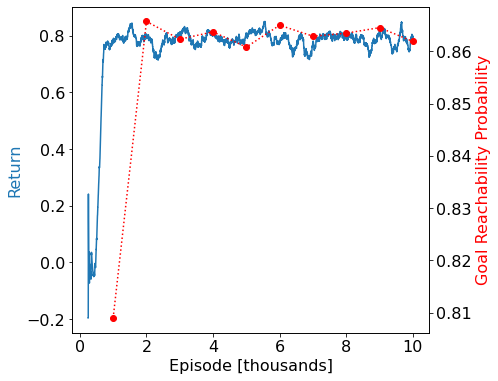

In [29]:
# take the grps from the analysis
results = results_cdrive
grps = []
x_grps = []
for episode in sorted(results_cdrive):
    x_grps.append(episode+1)
    grps.append(results[episode])
x_grps = np.array(x_grps)/1000

# load the scores from experiment
experiment = storage.Experiment.load('../experiments/learn_cdrive/cdrive/2022_01_20_133149959763_0_664e5/')
scores = experiment.scores()

# parameters for sliding mean
max_len = len(scores)
batch_size = 250
# calculate the sliding mean
d = []
sliding_means = []
for i, score in enumerate(scores[batch_size-1:max_len]):
    if i < batch_size:
        d.append(score)
    else:
        d[i%batch_size] = score
    new_value = np.mean(d)
    sliding_means.append(new_value)
    
# plot sliding mean and grp
fontsize = 16
fig, ax1 = plt.subplots(figsize=[6.4, 6])
ax2 = ax1.twinx()

x_means = (np.array(range(len(sliding_means)))+batch_size)/1000
ax1.plot(x_means, sliding_means, label = 'cdrive.2', color = 'tab:blue')
ax2.plot(x_grps, grps, linestyle = "dotted", color = "red", marker = 'o')

ax1.set_xlabel('Episode [thousands]', fontsize = fontsize)
ax1.set_ylabel('Return', fontsize = fontsize, color = 'tab:blue')
ax1.tick_params(labelsize = fontsize)
ax2.tick_params(labelsize=fontsize)
ax2.set_ylabel("Goal Reachability Probability", fontsize=fontsize, color = "red")

fig.savefig("../cdrive-plot.pdf", bbox_inches="tight")
fig.savefig("../cdrive-plot.png", bbox_inches="tight")

# 3. Assessing the Quality of an Arbitrary Decision Agent

In addition to checking the quality of an NN, MoGym also makes it possible to check arbitrary decision agents given as a Python function by connecting it to `modes` to resolve nondeterminism. For demonstration purposes, we here use a very simple decision agent, which always chooses the first applicable action. Clearly, this results in a very bad goal probability of 0. The execution takes about 1 minute, please wait for the output even if the notebook already pretends to be idle.

In [31]:
def oracle(state, available):
    """ This is of course a very dumb driver! """
    return 1

# We use the asynchronous API here for compatibility with Jupyter Lab. As a result, it
# may seem as if the cell has terminated although this is not the case. You will see the
# output of `modes` which indicates the probability.
loop.create_task(checker.check_oracle_async(learn_racetrack.network, learn_racetrack.controlled_instance, oracle))

<Task pending name='Task-3' coro=<check_oracle_async() running at /home/koehlma/momba-learning/.venv/lib/python3.9/site-packages/momba/gym/checker.py:175>>

Address: localhost:39085




model.jani:model: info: Featured Racetrack is an MDP model and will be simulated as an MDP.
model.jani: info: Using default value of 0.95 for the confidence parameter.
model.jani: info: Using default value of 0.01 for the absolute half-width parameter.


The Modest Toolset (www.modestchecker.net), version v3.1.107-g50c678139.


New connection from ('127.0.0.1', 43038).
Features: 15, Actions: 9

Peak memory usage: 105 MB
Analysis results for model.jani
Status:          Finished
Simulation time: 9.4 s

+ Property goalProbability
  Estimated probability: 0
  Runs used:             490
  Run type:              MDP
  Status:                Finished

  + Error bounds
    Statement: Adaptive: P(error > ε) < δ
    ε:         0.01
    δ:         0.050000000000000044

